初始化环境

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession # SparkSession 是Spark 2.0版本的新入口
spark = SparkSession.builder.master('local').getOrCreate()

In [2]:
row_data = spark.read.csv(path="hdfs://localhost:9000/user/bdlab/lab2/USCensus1990.data.txt",header=True,inferSchema=True)

In [3]:
row_data.take(1)

[Row(caseid=10000, dAge=5, dAncstry1=0, dAncstry2=1, iAvail=0, iCitizen=0, iClass=5, dDepart=3, iDisabl1=2, iDisabl2=2, iEnglish=1, iFeb55=0, iFertil=1, dHispanic=0, dHour89=4, dHours=3, iImmigr=0, dIncome1=2, dIncome2=0, dIncome3=0, dIncome4=1, dIncome5=0, dIncome6=0, dIncome7=0, dIncome8=0, dIndustry=10, iKorean=0, iLang1=1, iLooking=0, iMarital=1, iMay75880=0, iMeans=1, iMilitary=4, iMobility=2, iMobillim=2, dOccup=3, iOthrserv=0, iPerscare=2, dPOB=0, dPoverty=2, dPwgt1=1, iRagechld=4, dRearning=3, iRelat1=0, iRelat2=0, iRemplpar=0, iRiders=3, iRlabor=1, iRownchld=0, dRpincome=3, iRPOB=22, iRrelchld=0, iRspouse=3, iRvetserv=0, iSchool=1, iSept80=0, iSex=1, iSubfam1=0, iSubfam2=0, iTmpabsnt=0, dTravtime=5, iVietnam=0, dWeek89=2, iWork89=1, iWorklwk=1, iWWII=0, iYearsch=11, iYearwrk=1, dYrsserv=0)]

In [4]:
row_data.count()

2458285

In [5]:
data = row_data.rdd

# 抽样测试
* 选取最佳k值
* 初始化聚类中心

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
sample_data = row_data.sample(0.01) # 抽样 1%
sample_pd = sample_data.toPandas()

In [8]:
sample_pd = sample_pd.iloc[:,1:].values # 第一列无用

样本数据标准化

In [47]:
from sklearn.preprocessing import StandardScaler
sample_pd = StandardScaler().fit_transform(sample_pd)

In [48]:
# 保存抽样
np.savetxt("sample_std_array.txt",sample_pd)

In [9]:
# 加载抽样
sample_pd = np.loadtxt("sample_std_array.txt")

In [49]:
sample_pd.shape

(24628, 68)

In [10]:
from sklearn.cluster import KMeans

In [51]:
SSE = []  # 存放每次结果的误差平方和
for k in range(1,13):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(sample_pd)
    SSE.append(estimator.inertia_)
    print("k={}, SSE={}".format(k,SSE[-1]))

k=1, SSE=1674704.0000000002
k=2, SSE=1328927.7399816418
k=3, SSE=1135042.307368246
k=4, SSE=1067560.372383153
k=5, SSE=1018398.7434226715
k=6, SSE=971948.8169754281
k=7, SSE=943190.3577651557
k=8, SSE=923002.3750831345
k=9, SSE=881972.0964427008
k=10, SSE=870906.5903082998
k=11, SSE=857028.3218245438
k=12, SSE=824949.4245692719


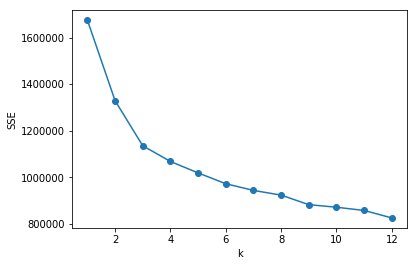

In [52]:
plt.xlabel("k")
plt.ylabel("SSE")
plt.plot(range(1,13),SSE,marker='o')

                根据手肘法,选定k=3或4

In [11]:
estimator = KMeans(n_clusters=3)  # 构造聚类器
estimator.fit(sample_pd)
km_result = estimator.labels_
km_center = estimator.cluster_centers_ # 作为整体数据初始聚类中心

PCA降维,绘图

In [54]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
sample_pca = pca.fit_transform(sample_pd)

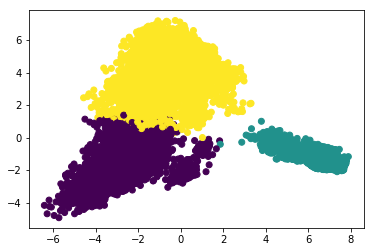

In [59]:
plt.scatter(sample_pca[:,0],sample_pca[:,1],c=km_result)
plt.show()

            经测试 k=3 有较好分类效果



# 聚类

k = 期望簇数

delta = 可接受的收敛误差

max_iter = 最大迭代次数

data = 输入数据


1. 初始化质心

2. map：对每个向量，计算当前向量到各中心的距离，更新最近的中心
    
    输入：向量
    
    输出：（最近的中心，向量）

3. reduce：根据所有map输出，重新计算所有簇的平均值，重新创建质心
    
    输入：iterable 向量
    
    输出：key.id，新质心= avg(list向量)
    
4. change:比较新旧质心的变化，若变化量小于delta，判定收敛，算法终止

    输入：新质心，旧质心
    
    输出：新旧质心距离（向量）
      
       

In [12]:
k = 3
delta = 0.0001
max_iter = 300
initial_centroids = km_center

In [13]:
data = data.map(lambda x:x[1:])

In [27]:
current_centroids = initial_centroids

定义功能函数

In [14]:
# 计算两向量的欧氏距离
def eucDis(x,y):
    sumdis = 0
    for i,j in zip(x,y):
        sumdis += (i-j)**2
    return sumdis**0.5

# Vector 求和
def vecAdd(x):
    vecres=[]
    for i in range(len(x[0])):
        sumi = 0
        for j in x:
            sumi += j[i]
        vecres.append(sumi)
    return vecres

# 计算质心变化
def change(new,current):
    new_d = eucDis(vecAdd(new),vecAdd(current))
    return new_d if new_d>=0 else -new_d

mapper 对Vector分类

In [26]:
def nearest_mapper(vec):
    """
    Parameters:
        vec: input vector
    Returns:
        nearest: the nearest center id
        x: input x
        1: counter
    """
    x = vec
    nearest = -1
    nearest_dis = -1
    for i in range(k):
        dis = eucDis(x,current_centroids[i])
        if nearest == -1:
            nearest = i
            nearest_dis = dis
        else:
            if dis<nearest_dis:
                nearest = i
                nearest_dis = dis 
    return (nearest,(x,1))

reducer 重新计算质心

In [16]:
def center_reducer(x,y):
    return (vecAdd([x[0],y[0]]),x[1]+y[1])

In [32]:
# 调整数据格式作为输入
data_dev = data.map(lambda x:(0,(x,1)))

In [ ]:
def k_means(data=data_dev,k=3,delta = 0.0001,max_iter = 300,initial_centroids = km_center):
    # 初始化迭代计数器
    iter_cnt = 0
    # 初始化簇质心
    current_centroids = initial_centroids    
    # 迭代
    while True:
        cent_rdd = data_dev.reduceByKey(center_reducer)
        
        new_centroids
        iter_cnt +=1
        # TODO: 输出迭代信息
        if change(new_centroids,current_centroids)<delta :
            # 收敛
            break;
        if iter_cnt >= max_iter :
            # 达到最大迭代次数
            break;
        current_centroids = new_centroids
    return data    